# Stochastic Gradient Langevin Dynamics I: Basics

## Description:

Langevin dynamics is an updating scheme that generates samples of $x$ considering the gradient of an energy function $U(x)$ and adding a bit of brownian noise. The updating scheme with exact gradient is $$x_{k+1} = x_k - s_k \nabla U(x_k) + \sqrt{2 s_k \tau}\xi_k $$ where $s_k$ is the step size as a function of $k$, and goes to zero as $k$ approaches infinity. $\tau$ is called temperature, and $\xi_k$ follows a standard normal distribution. In the end, the sampled distribution of $x$ should approach $e^{-U(x)}$ with a constant factor, i.e. the distrbution should have peaks where the energy function $U$ is small.

We use easily defined energy functions and their exact gradients in this demo.

We start with convex functions, and then experiment with multi-modal functions. The goal is to see how Langevin dynamics works, and how different parameters (e.g. learning steps, temperature) affects the learning process.

In [1]:
# general imports
import numpy
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

## Case 1: convex function
- Energy function: $y = x^2$
- Temperature included, variable
- Step size: $\frac{1}{k+5}$

In [2]:
# energy function: quadratic
# energy function
x = numpy.linspace(-1, 1, 200)
f = lambda x : x**2
f_prime = lambda x : 2*x # gradient, in this case exact

# plotting
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(x, f(x))
# ax.plot(x, numpy.exp(-f(x)))
# plt.show()

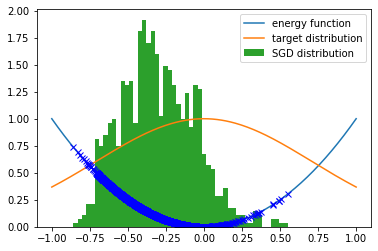

In [3]:
# apply SGD
# setup
x_sgd = []
x_0 = -0.8 # initial guess
N = 1000 # number of iterations
temp = 0.25 # temperature
step = lambda x : 1 / (x+5) # step size, goes to zero
x_sgd.append(x_0)

# Langevin iteration
for i in range(N):
    x_new = x_sgd[i] - f_prime(x_sgd[i]) * step(i) + numpy.sqrt(2 * step(i) * temp) * (numpy.random.normal(0,1))
    x_sgd.append(x_new)
x_sgd = numpy.array(x_sgd)

# plotting
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, f(x), label = "energy function")
ax.plot(x, numpy.exp(-f(x)), label = "target distribution")
ax.hist(x_sgd, bins = 50, density = True, label = "SGD distribution")
ax.plot(x_sgd, f(x_sgd), 'bx')
ax.legend()
plt.show()

## Case 2: polynomial, multiple local minima

- energy function: $f(x) = 0.4 x^8 + 3x^5 + 5 x^2 $. There is a local minimum at zero, and a global minimum at around -1.6.
- we start with an initial guess of -0.8, which is around the local minimum at zero, but getting to the global minimum will require extra work.
- Temperature included, fixed throughout iteration.
- step size: $s = \frac{1}{(\log{(2k+1)}+5)^2}$. Notice the additional power. This is needed otherwise the iteration causes overflow because of the high power of the polynomials.

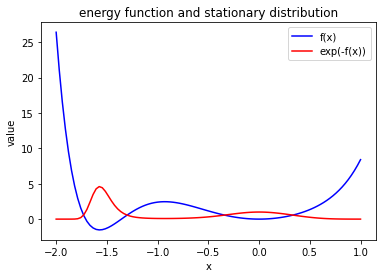

In [4]:
# energy function
x = numpy.linspace(-2, 1, 100)
f = lambda x : 0.4 * (x**8) + 3 * (x**5) + 5 * (x**2)
f_prime = lambda x : 3.2 * (x**7) + 15 * (x**4) + 10 * x

# plotting
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, f(x), 'b', label = "f(x)")
ax.plot(x, numpy.exp(-f(x)), 'r', label = "exp(-f(x))")
ax.set_xlabel("x")
ax.set_ylabel("value")
ax.set_title("energy function and stationary distribution")
ax.legend()
plt.show()

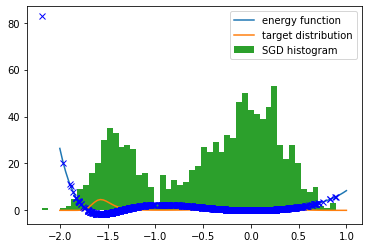

In [5]:
# SGD setup
n = 1000
s = lambda x : 1 / (numpy.log(3*x+1)+5)**2 # the power is necessary, without which the iteration blows up
# s = lambda x : 1 / (x+5)**2 # step size, goes to zero, again the power is necessary

# apply SGD, write as function

def sgld(f, f_prime, N, temp, step, x_0, limit = None):
    '''
    Parameters:
     N: number of iterations
     temp: temperature of iteration
     step: step size, as a function of iteration count, must go to zero
     x_0: initial guess
     limit: a range optinally enforced on x; if x is out of range, then it's forced to the lower or upper bound
     
    Returns: a numpy array of sampled x's
    '''
    
    x_sgd = numpy.empty(N)
    x_sgd[0] = x_0
    
    for i in range(N-1):
        x_new = x_sgd[i] - f_prime(x_sgd[i]) * step(i) + numpy.sqrt(2 * step(i) * temp) * (numpy.random.normal(0,1))
        if limit != None:
            if  x_new > limit[1]:
                x_new = limit[1]
            elif x_new < limit[0]:
                x_new = limit[0]
        x_sgd[i+1] = x_new
    
#         if i < 100:
#             print(x_sgd[i])
    
    return x_sgd

result = sgld(f, f_prime, n, 2, s, -0.8)

# plotting
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, f(x), label = "energy function")
ax.plot(x, numpy.exp(-f(x)), label = "target distribution")
ax.hist(result, bins = 50, density = False, label = "SGD histogram")
ax.plot(result, f(result), 'bx')
ax.legend()
plt.show()

- Remarks:

1. it was shown that a $\frac{1}{log(k)}$ step size is somewhat optimal. The additional power was necessary to prevent overflow.
2. the local minimum received more attention then it should.

## Some comparisons and graphing

From now on, we will use the following multi-modal function: $$f(x) = x^2 - \cos(\pi x) + x$$

The gradient is computed exactly: $$f'(x) = 2x + \pi \sin(\pi x) + 1$$

A plot of the function shows that the global minimum is attained at about -0.085, while there is another local minimum at about -1.72, a local maximum at around -1.13.

We will generate stage-wise graph for iterations, e.g. one graph per one tenth of iteration, to see the evolvement of the distribution of samples. We will also compare effects caused by different temperatures. In theory, a lower temperature should lead to a more concentrated search. When the initial guess is "good", a lower temperature chain intuitively should converge faster to the global minimum. However, when the initial guess is misleading, it should take longer for the low temperature chain to discover the true global minimum.

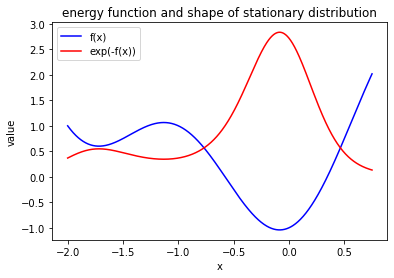

In [6]:
x = numpy.linspace(-2, 0.75, 1000)
f = lambda x : x**2 - numpy.cos(numpy.pi*x) + x
f_prime = lambda x : 2*x + numpy.pi * numpy.sin(numpy.pi*x) + 1

# plotting
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, f(x), 'b', label = "f(x)")
ax.plot(x, numpy.exp(-f(x)), 'r', label = "exp(-f(x))")
ax.set_xlabel("x")
ax.set_ylabel("value")
ax.set_title("energy function and shape of stationary distribution")
ax.legend()
plt.show()

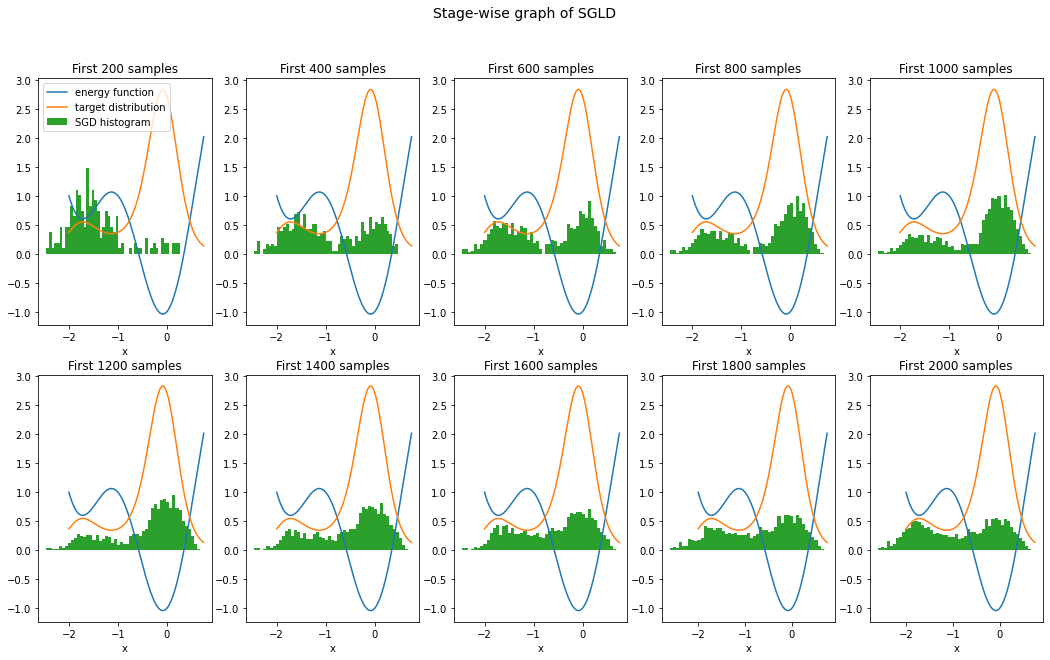

In [7]:
# setup and conditions:
n = 2000
s_log_sq = lambda x : 1 / (numpy.log(2*x+1)+5)**2
t = 1
guess = -1.3
interval = None # x will be generated without limit

# run SGLD
result = sgld(f, f_prime, n, temp = t, step = s_log_sq, x_0 = guess, limit = interval)

# stage-wise plotting
fig = plt.figure(figsize=(18, 10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.plot(x, f(x), label = "energy function")
    ax.plot(x, numpy.exp(-f(x)), label = "target distribution")
    ax.hist(result[:len(result)*(i+1)//10], bins = 50, density = True, label = "SGD histogram")
    #the line below is most useful for small number of iterations
    #ax.plot(result[:len(result)*(i+1)//10], f(result[:len(result)*(i+1)//10]), 'bx', label = "sampled x")
    if i == 0:
        ax.legend()
    ax.set_xlabel("x")
    ax.set_title("First {n} samples".format(n=len(result)*(i+1)//10))
fig.suptitle("Stage-wise graph of SGLD", fontsize=14)
plt.show()

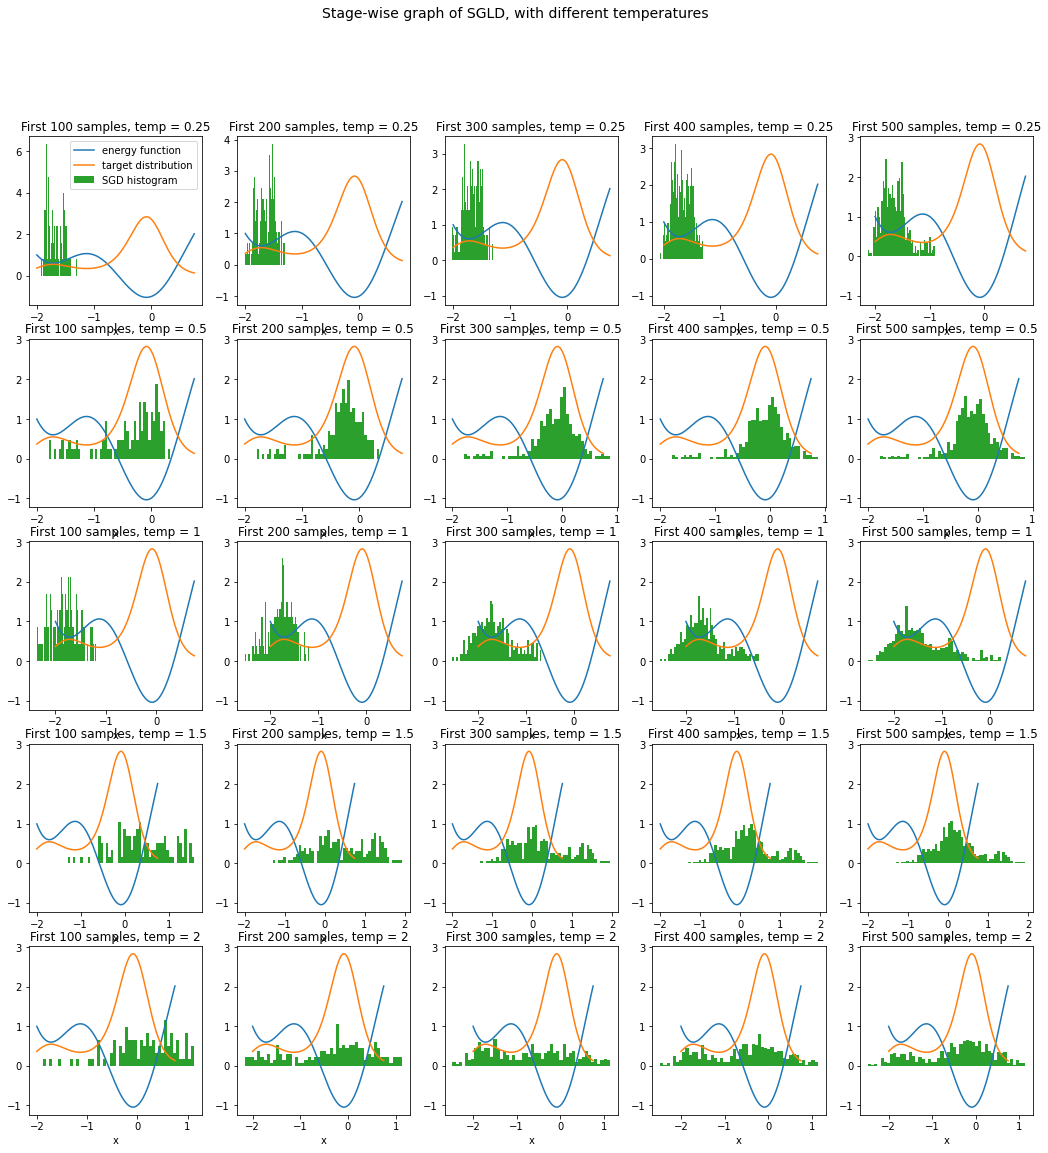

In [9]:
# comparing how temperature affects SGLD
N = 500
s_log_sq = lambda x : 1 / (numpy.log(2*x+1)+5)**2
guess = -1.3
t_li = [0.25, 0.5, 1, 1.5, 2]
interval = None # x will be generated without limit

res_li = []

for tem in t_li:
    res_li.append(sgld(f, f_prime, N, temp = tem, step = s_log_sq, x_0 = guess, limit = interval))

# plotting and comparing different temperatures
fig = plt.figure(figsize=(18, 18))
count = 0
for i in range(len(t_li)):
    for j in range(5):
        ax = fig.add_subplot(len(t_li), 5, count+1)
        ax.plot(x, f(x), label = "energy function")
        ax.plot(x, numpy.exp(-f(x)), label = "target distribution")
        ax.hist(res_li[i][:len(res_li[i])*(j+1)//5], bins = 50, density = True, label = "SGD histogram")
        #the line below is most useful for small number of iterations
        #ax.plot(result[:len(result)*(i+1)//10], f(result[:len(res_li[i])*(i+1)//10]), 'bx', label = "sampled x")
        if count == 0:
            ax.legend()
        ax.set_xlabel("x")
        ax.set_title("First {n} samples, temp = {t}".format(n=len(res_li[i])*(j+1)//5, t=t_li[i]))
        count += 1
fig.suptitle("Stage-wise graph of SGLD, with different temperatures", fontsize=14)
plt.show()
